<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/l5_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipdb

     |████████████████████████████████| 793 kB 13.9 MB/s 
     |████████████████████████████████| 380 kB 70.8 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=fd9ea4977bb6268944b4964a30ade4a857a3c3e743c601eb58acec0c9fa69641
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2022-03-04 00:41:11--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  17.4MB/s    in 0.3s    

2022-03-04 00:41:12 (17.4 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]



In [ ]:
!ls

ml-100k.zip  ml-100k.zip.1  sample_data


In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [2]:
from fastai import *
from fastai.vision import *
from fastai.collab import *
from ipdb import set_trace as st

In [ ]:
import pandas as pd
path = Path('/content/ml-100k')
df = pd.read_csv(path/'u.data', header = None, delimiter = '\t', names = ['u_id', 'm_id', 'rating', 'ts'])
data = CollabDataBunch.from_df(df, user_name = 'u_id', item_name = 'm_id', rating_name = 'rating')
data.show_batch()

u_id,m_id,target
753,182,3.0
663,710,3.0
291,223,5.0
758,234,4.0
196,269,3.0


epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


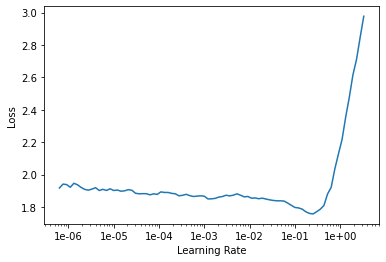

In [ ]:
learn = collab_learner(data, n_factors = 40, y_range = [0, 5.5], bn_final = True, wd = 1e-02, metrics = abs_error)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,abs_error,time
0,1.159697,1.148571,0.883734,00:10


In [3]:
# u, m = max(set(df["u_id"])), max(set(df['m_id']))

def abs_error(yhat, y):
  yhat, y = yhat.squeeze(), y.squeeze()
  return torch.mean(torch.abs(yhat - y))

class MyCollab(nn.Module):
  def __init__(self, n_factors, y_range):
    super().__init__()
    nu, ni = u + 1, m + 1
    self.u, self.u_b, self.i, self.i_b = [nn.Embedding(i, j) for i, j in [(nu, n_factors), (nu, 1), (ni, n_factors), (ni, 1)]]
    self.y_range = y_range

  def rangify(self, yhat):
    yhat = torch.sigmoid(yhat)
    # print('d, ', yhat.shape)
    res = (yhat * (self.y_range[1] - self.y_range[0])) + self.y_range[0]
    # print('e, ', res.shape)
    return res

  def forward(self, ud, id):
    # print('a, ', ud.shape, id.shape, max(ud), max(id))
    yhat = torch.sum(self.u(ud) * self.i(id), 1)
    # print('b, ', yhat.shape)
    yhat += self.u_b(ud).squeeze(1) + self.i_b(id).squeeze(1)
    # print('c, ' , yhat.shape)
    return self.rangify(yhat)


In [ ]:
x, y = next(iter(data.valid_dl))

In [ ]:
collab = MyCollab(40, [0, 5.5]).cuda()
my_learner = CollabLearner(data, collab, metrics = abs_error, wd = 1e-01)

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


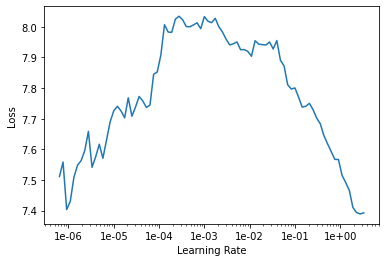

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()

In [ ]:
my_learner.save('st_1')

In [ ]:
my_learner.load('st_1')
my_learner.fit(3, lr = 1e-02)

epoch,train_loss,valid_loss,abs_error,time
0,1.109462,1.110967,0.838212,00:08
1,0.881006,0.917615,0.764070,00:08
2,0.821404,0.915065,0.762085,00:08


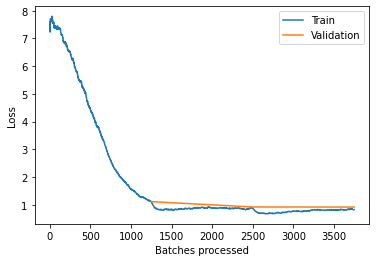

In [ ]:
my_learner.recorder.plot_losses()

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


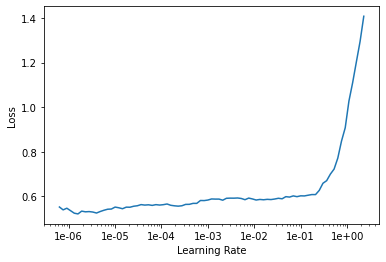

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()

In [ ]:
my_learner.save('st_2')

In [ ]:
my_learner.load('st_2')
my_learner.fit(3, lr = 1e-03  )

epoch,train_loss,valid_loss,abs_error,time
0,0.550358,0.872527,0.744443,00:08
1,0.515207,0.863807,0.740663,00:09
2,0.475786,0.863827,0.740246,00:08


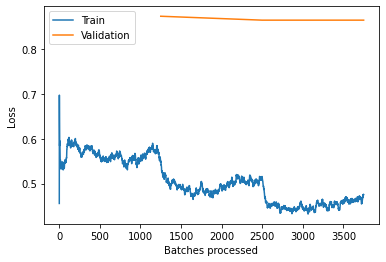

In [ ]:
my_learner.recorder.plot_losses()

In [ ]:
emb = nn.Embedding(20, 10)

In [ ]:
for i in emb.parameters():
  w = i
w.shape

torch.Size([20, 10])

In [ ]:
torch.mean(w[0]), torch.mean(w), torch.std(w[0]), torch.std(w)

(tensor(-0.4227, grad_fn=<MeanBackward0>),
 tensor(-0.0238, grad_fn=<MeanBackward0>),
 tensor(0.3475, grad_fn=<StdBackward0>),
 tensor(0.8944, grad_fn=<StdBackward0>))

In [ ]:
torch.max(w), torch.min(w)

(tensor(2.4258, grad_fn=<MaxBackward1>),
 tensor(-2.8512, grad_fn=<MinBackward1>))

In [ ]:
with torch.no_grad():
  st()
  emb.weight.normal_()

In [3]:
from fastai.datasets import untar_data
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [4]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/7')]

In [6]:
#test
from fastai.vision.image import open_image
img = open_image((path/'training'/'1').ls()[10])
img.data.reshape(2352).shape

torch.Size([2352])

In [5]:
import random
valid_index = random.sample(range(60000), 12000)

x, y = [], []

for i in (path/'training').ls():
  for j in (path/'training'/i).ls():
    x.append(open_image((path/'training'/i/j)).data.reshape(2352))
    y.append(torch.tensor(int(i.name)))

x_train, y_train, x_valid, y_valid = [], [], [], []

for i in range(60000):  
  if (i in valid_index):
    x_valid.append(x[i])
    y_valid.append(y[i])
  else:
    x_train.append(x[i])
    y_train.append(y[i])

x_train = torch.stack(x_train)
x_valid = torch.stack(x_valid)
y_train = torch.stack(y_train)
y_valid = torch.stack(y_valid)

In [8]:
y_train.shape

torch.Size([48000])

In [6]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [7]:
from fastai.basic_data import DataBunch
data = DataBunch.create(train_ds = train_ds, valid_ds = valid_ds)

In [24]:
x, y = next(iter(data.train_dl))

In [11]:
x.shape, y.shape

(torch.Size([64, 2352]), torch.Size([64]))

In [12]:
lin = nn.Linear(in_features = 2352, out_features = 10).cuda()

In [26]:
yhat = lin(x)

In [14]:
for i in lin.parameters():
  print(i.dtype)

torch.float32
torch.float32


In [27]:
loss_func = nn.CrossEntropyLoss()
loss_func(yhat, y)

tensor(0.2523, device='cuda:0', grad_fn=<NllLossBackward0>)

In [8]:
from torch.nn.parameter import Parameter
class Linear(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()
    self.w = Parameter(torch.rand(n_in, n_out, dtype = torch.float32, device = 'cuda').uniform_(-torch.sqrt(torch.tensor(1/n_in)), torch.sqrt(torch.tensor(1/n_in))))
    # self.bias = Parameter(torch.rand(n_out, 1, dtype = torch.float32, device = 'cuda').squeeze().uniform_(torch.tensor(1/n_in), torch.tensor(1/n_in)))
    self.bias = Parameter(torch.zeros(n_out))
    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.relu(torch.matmul(x, self.w) + self.bias)

In [18]:
yhat = lin(x)

In [14]:
lin = Linear(2352, 10).cuda()

def update(lr = 1e-01, model = lin):
  c = 0
  for x, y in iter(data.train_dl):
    # st()
    yhat = model(x)
    loss = loss_func(yhat, y)
    if (c % 50 == 0):
      print(loss.item())
    loss.backward()
    c += 1
    with torch.no_grad():
      for param in model.parameters():
        param.sub_(lr*param.grad)
        param.grad.zero_()

In [15]:
update()

2.2999324798583984
0.4516780376434326
0.3547632694244385
0.37521976232528687
0.473797470331192
0.2618030309677124
0.3647060990333557
0.2833253741264343
0.4686231017112732
0.35707104206085205
0.36474764347076416
0.47151869535446167
0.25000759959220886
0.21950891613960266
0.5717940926551819


In [16]:
vx, vy = next(iter(data.valid_dl))
vyhat = lin(vx)

In [17]:
loss_func(vyhat, vy)

tensor(0.4210, device='cuda:0', grad_fn=<NllLossBackward0>)

In [18]:
temp = vyhat.argmax(1)
temp, vy

(tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 8, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2], device='cuda:0'),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'))

In [19]:
def accuracy(yhat, y):
  return 100 * torch.sum(yhat.argmax(1) == y)/len(y)

In [20]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = lin(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.3303, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(90.6250, device='cuda:0'))

In [22]:
class NormalLinear(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()
    self.w = Parameter(torch.rand(n_in, n_out, dtype = torch.float32, device = 'cuda').normal_(0, torch.sqrt(torch.tensor(1/n_in))))
    # self.bias = Parameter(torch.rand(n_out, 1, dtype = torch.float32, device = 'cuda').squeeze().uniform_(torch.tensor(1/n_in), torch.tensor(1/n_in)))
    self.bias = Parameter(torch.zeros(n_out))
    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.relu(torch.matmul(x, self.w) + self.bias)

In [30]:
class NewLearner(nn.Module):
  def __init__(self, layers = []):
    super().__init__()
    self.layers = layers
    ws = [nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)]
    self.ws = nn.Sequential(*ws)
  
  def forward(self, x):
    return self.ws(x)

my_model = MyLearner(layers = [2352, 100, 10]).cuda()
yhat = my_model(x)
loss_func(yhat, y)

tensor(2.3254, device='cuda:0', grad_fn=<NllLossBackward0>)

In [31]:
class MyLearner(nn.Module):
  def __init__(self, layers = []):
    super().__init__()
    self.layers = layers
    ws = [Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)]
    self.ws = nn.Sequential(*ws)
  
  def forward(self, x):
    return self.ws(x)
  
new_learner = NewLearner(layers = [2352, 100, 10]).cuda()
yhat = new_learner(x)
loss_func(yhat, y)

tensor(2.3015, device='cuda:0', grad_fn=<NllLossBackward0>)

In [32]:
class NormalLearner(nn.Module):
  def __init__(self, layers = []):
    super().__init__()
    self.layers = layers
    ws = [NormalLinear(layers[i], layers[i+1]) for i in range(len(layers) - 1)]
    self.ws = nn.Sequential(*ws)
  
  def forward(self, x):
    return self.ws(x)
  
new_learner = NewLearner(layers = [2352, 100, 10]).cuda()
yhat = new_learner(x)
loss_func(yhat, y)

tensor(2.2893, device='cuda:0', grad_fn=<NllLossBackward0>)

In [33]:
model = MyLearner(layers = [2352, 100, 10]).cuda()
update(lr = 1e-01, model = model)

2.2999422550201416
0.8273811340332031
0.7245279550552368
0.596630334854126
0.7133972644805908
0.4946950376033783
0.5374793410301208
0.5980111360549927
0.7081258296966553
0.3204316794872284
0.7164708375930786
0.5420923233032227
0.5954591035842896
0.3052597641944885
0.7167553901672363


In [34]:
my_model = NewLearner(layers = [2352, 100, 10]).cuda()
update(lr = 2e-01, model = my_model)

2.3210363388061523
0.43578478693962097
0.3945179283618927
0.5340788960456848
0.5162561535835266
0.29197630286216736
0.4172360301017761
0.4501933157444
0.4201132655143738
0.23267492651939392
0.3623475730419159
0.4717099070549011
0.23108690977096558
0.3204061686992645
0.4303533434867859


In [35]:
normal_model = NormalLearner(layers = [2352, 100, 10]).cuda()
update(lr = 1e-01, model = normal_model)

2.326955556869507
0.5538337826728821
0.27853912115097046
0.2826082408428192
0.3548614978790283
0.1729215681552887
0.34639444947242737
0.4057809114456177
0.3088633716106415
0.1862310916185379
0.3903025984764099
0.25157010555267334
0.3164891302585602
0.22575680911540985
0.15238410234451294


In [36]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = model(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.4509, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(84.3584, device='cuda:0'))

In [38]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = my_model(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.3266, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(90.6416, device='cuda:0'))

In [39]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = normal_model(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(93.7915, device='cuda:0'))

In [42]:
def update_wd(lr = 1e-01, model = lin, wd = 1e-02):
  c = 0
  losses = []
  for x, y in iter(data.train_dl):
    # st()
    yhat = model(x)
    
    wsum = 0
    for i in model.parameters():
      wsum += (i**2).sum()

    loss = loss_func(yhat, y) + wd*wsum

    if (c % 50 == 0):
      print(loss.item())
    losses.append(loss.item())
    loss.backward()
    c += 1
    with torch.no_grad():
      for param in model.parameters():
        param.sub_(lr*param.grad)
        param.grad.zero_()
  return losses

In [43]:
normal_model = NormalLearner(layers = [2352, 200, 50, 10]).cuda()
t_losses = update_wd(lr = 1e-01, model = normal_model, wd = 1e-04)

2.33591365814209
0.8251221179962158
0.4590650200843811
0.2780056893825531
0.37270936369895935
0.405471533536911
0.4734379053115845
0.35572221875190735
0.09140753746032715
0.2469153106212616
0.3334296643733978
0.22343896329402924
0.18826887011528015
0.2249823361635208
0.21207939088344574


In [44]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = normal_model(vx)
  losses.append(loss_func(vyhat, vy))
  
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.1756, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(94.7556, device='cuda:0'))

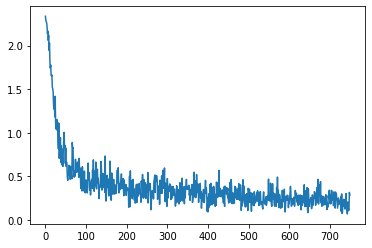

In [45]:
plt.plot(t_losses)

In [71]:
def update_wd_momentum(lr = 1e-01, model = lin, wd = 1e-02, alpha = 0.9):
  c = 0
  losses = []
  prev_updates = {}
  for x, y in iter(data.train_dl):
    # st()
    yhat = model(x)
    
    wsum = 0
    for i in model.parameters():
      wsum += (i**2).sum()

    loss = loss_func(yhat, y) + wd*wsum

    if (c % 50 == 0):
      print(loss.item())
    losses.append(loss.item())
    loss.backward()
    c += 1

    with torch.no_grad():
      for param in model.parameters():
        update = param.grad
        # momentum part
        if (update.shape in prev_updates):
          update = (1 - alpha)*update + alpha*prev_updates[update.shape]

        param.sub_(lr*update)
        prev_updates[update.shape] = update
        param.grad.zero_()

  return losses

2.3039896488189697
0.6474356055259705
0.31230926513671875
0.45937851071357727
0.30645206570625305
0.39116889238357544
0.46920138597488403
0.4104722738265991
0.4498608708381653
0.45732471346855164
0.2542753517627716
0.32638999819755554
0.2647510766983032
0.26414328813552856
0.19943103194236755


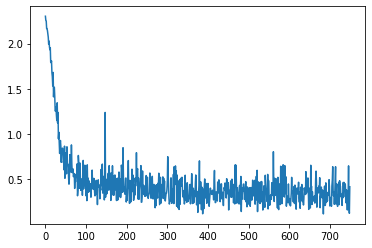

In [81]:
model = NewLearner(layers = [2352, 200, 50, 10]).cuda()
t_losses = update_wd_momentum(lr = 1e-01, model = model, wd = 1e-04, alpha = 0.9)
plt.plot(t_losses)

In [82]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = normal_model(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.1856, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(94.4149, device='cuda:0'))

In [56]:
a = torch.randn(2, 2)
a**2, a

(tensor([[0.6562, 0.0092],
         [0.2316, 0.4458]]), tensor([[-0.8101,  0.0959],
         [-0.4812, -0.6677]]))

In [103]:
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f8f3695c850>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f8f3695c7d0>;

Test: None

In [100]:
def update_wd_rms_prop(lr = 1e-01, model = lin, wd = 1e-02, rms_coeff = 0.9):

  c = 0
  losses = []
  gradiant_squared_moving_avg = {}
  for x, y in iter(data.train_dl):

    yhat = model(x)
    
    wsum = 0
    for i in model.parameters():
      wsum += (i**2).sum()

    loss = loss_func(yhat, y) + wd*wsum

    if (c % 50 == 0):
      print(loss.item())
    losses.append(loss.item())
    loss.backward()
    c += 1
    
    alpha = (1 - rms_coeff)

    with torch.no_grad():
      for param in model.parameters():
        
        # RMS PRO
        if (param.shape in gradiant_squared_moving_avg):
          # st()
          gradiant_squared_moving_avg[param.shape] = alpha*param.grad**2 + (1 - alpha)*gradiant_squared_moving_avg[param.shape] 
          update = (lr/torch.sqrt(gradiant_squared_moving_avg[param.shape])) * param.grad
          param.sub_(update)

        else:
          
          param.sub_(lr*param.grad)
          gradiant_squared_moving_avg[param.shape] = param.grad**2

        param.grad.zero_()

  return losses

2.3428866863250732
0.596040666103363
0.39781761169433594
0.5655489563941956
0.58827143907547
0.22071540355682373
0.38126108050346375
0.44841110706329346
0.3816024363040924
0.4873497784137726
0.23696789145469666
0.2704204022884369
0.46289342641830444
0.37953829765319824
0.4349241554737091


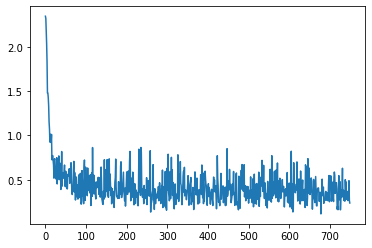

In [101]:
model = NewLearner(layers = [2352, 200, 50, 10]).cuda()
t_losses = update_wd_rms_prop(lr = 1e-03, model = model, wd = 1e-04, rms_coeff = 0.9)
plt.plot(t_losses)

In [152]:
def update_adam(lr = 1e-01, model = lin, wd = 1e-03, momentum = 0.9, rms_coeff = 0.99):

  c = 0
  losses = []
  gradiant_squared_moving_avg = {}
  update_moving_avg = {}
  for x, y in iter(data.train_dl):

    yhat = model(x)
    
    wsum = 0
    for i in model.parameters():
      wsum += (i**2).sum()

    loss = loss_func(yhat, y) + wd*wsum

    if (c % 50 == 0):
      print(loss.item())
    losses.append(loss.item())
    loss.backward()
    c += 1

    with torch.no_grad():
      for param in model.parameters():
        
        # RMS PRO
        if (param.shape in gradiant_squared_moving_avg):
          # st()            
          gradiant_squared_moving_avg[param.shape] = (1 - rms_coeff)*param.grad**2 + rms_coeff*gradiant_squared_moving_avg[param.shape] 

          update = ((lr/c)*param.grad/torch.sqrt(gradiant_squared_moving_avg[param.shape]))
          update = (1-momentum) * update + momentum * update_moving_avg[param.shape]
          param.sub_(update)

          update_moving_avg[param.shape] = update

        else:
          
          param.sub_(lr*param.grad)
          gradiant_squared_moving_avg[param.shape] = param.grad**2
          update_moving_avg[param.shape] = lr*param.grad

        param.grad.zero_()
  print(c)
  return losses

2.3280608654022217
0.5697374939918518
0.26244470477104187
0.5660898089408875
0.36554139852523804
0.44352462887763977
0.5649351477622986
0.4884936213493347
0.46179670095443726
0.45336025953292847
0.4423021376132965
0.41110655665397644
0.3300139009952545
0.5370196104049683
0.49679458141326904
750


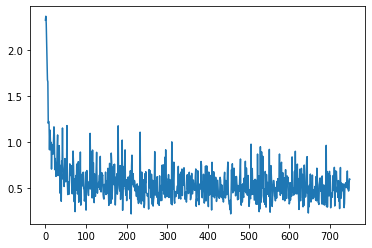

In [154]:
model = NewLearner(layers = [2352, 200, 50, 10]).cuda()
t_losses = update_adam(lr = 1e-2, model = model, wd = 5e-04)
plt.plot(t_losses)

In [155]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = model(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.3810, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(89.2952, device='cuda:0'))